# Simulating Channel Flow with Hot Wall [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tumaer/jax-sph/blob/main/notebooks/tutorial.ipynb)

This notebook demonstrates the main functionalities of the JAX-SPH solver covering:
* Case setup
    * Relaxation vs simulation
* Simulation components
    * Solver
    * Neighbor search
    * Integrator
* Run a simulation
* Visualize results

As `jax_sph.simulate.simulate(cfg)` essentially wraps the whole simulation, in this notebook we will unpack the contents of this function.

In [1]:
# install jax-sph if you haven't already
# !pip install git+https://github.com/tumaer/jax-sph.git

In [2]:
import os
import time

import jax.numpy as jnp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from jax import jit
from omegaconf import DictConfig, OmegaConf

from jax_sph import partition
from jax_sph.case_setup import SimulationSetup
from jax_sph.defaults import defaults
from jax_sph.integrator import si_euler
from jax_sph.io_state import io_setup, read_h5, write_state
from jax_sph.jax_md.partition import Sparse
from jax_sph.solver import WCSPH
from jax_sph.utils import Logger, Tag, pos_init_cartesian_2d
from jax_sph.visualize import plt_ekin


## Case setup

To run a simulation, two files defining the simulation case need to be provided: `*.py` and `*.yaml`. We provide a wide range of examples in `cases/`.

* `.py`: defines the psysical system, i.e.
    * geometry (`self.special.*`), 
    * box size (`box_size`), 
    * initial particle positions (`init_pos`), 
    * types of particles (`tag`), 
    * initial particle velocities (`init_velocity`), 
    * boundary condition enforcing function (`boundary_conditions_fn`).
* `.yaml`: configures a simulation run, i.e.
    * system params like seed, GPU, etc.
    * physical case (`case`) - including geometry-specific values, but also reference physical values (e.g. viscosity and velocity), particle spacing, etc.
    * SPH solver (`solver`),
    * SPH interpolation kernel (`kernel`),
    * Equation of state (`eos`),
    * Neighbor list (`nl`)
    * Input/output (`io`)

Used with the embedded config loading in our `main.py`, the YAML file can inherit from other yaml files with `extends: source_case.yaml`, or from the defaults we define in `jax_sph/defaults.py` by using `extends: JAX_SPH_DEFAULTS`.

Our tutorial will be based on the channel flow with heat transfer, so we start with the SimulationSetup from `cases/ht.py` given below.

In [3]:
### Replacement for a Python case file. Copied from cases/ht.py

class HT(SimulationSetup):
    "Heat Transfer"

    def __init__(self, cfg: DictConfig):
        super().__init__(cfg)

        # define offset vector
        self.offset_vec = self._offset_vec()

        # relaxation configurations
        if self.case.mode == "rlx":
            self._set_default_rlx()

        if self.case.r0_type == "relaxed":
            self._load_only_fluid = False
            self._init_pos2D = self._get_relaxed_r0
            self._init_pos3D = self._get_relaxed_r0

    def _box_size2D(self, n_walls):
        dx2n = self.case.dx * n_walls * 2
        sp = self.special
        return np.array([sp.L, sp.H + dx2n])

    def _box_size3D(self, n_walls):
        dx2n = self.case.dx * n_walls * 2
        sp = self.special
        return np.array([sp.L, sp.H + dx2n, 0.5])

    def _init_walls_2d(self, dx, n_walls):
        sp = self.special

        # thickness of wall particles
        dxn = dx * n_walls

        # horizontal and vertical blocks
        horiz = pos_init_cartesian_2d(np.array([sp.L, dxn]), dx)

        # wall: bottom, top
        wall_b = horiz.copy()
        wall_t = horiz.copy() + np.array([0.0, sp.H + dxn])

        rw = np.concatenate([wall_b, wall_t])
        return rw

    def _init_walls_3d(self, dx, n_walls):
        pass

    def _init_pos2D(self, box_size, dx, n_walls):
        sp = self.special

        # initialize fluid phase
        r_f = np.array([0.0, 1.0]) * n_walls * dx + pos_init_cartesian_2d(
            np.array([sp.L, sp.H]), dx
        )

        # initialize walls
        r_w = self._init_walls_2d(dx, n_walls)

        # set tags
        tag_f = jnp.full(len(r_f), Tag.FLUID, dtype=int)
        tag_w = jnp.full(len(r_w), Tag.SOLID_WALL, dtype=int)

        r = np.concatenate([r_w, r_f])
        tag = np.concatenate([tag_w, tag_f])

        # set thermal tags
        _box_size = self._box_size2D(n_walls)
        mask_hot_wall = (
            (r[:, 1] < dx * n_walls)
            * (r[:, 0] < (_box_size[0] / 2) + self.special.hot_wall_half_width)
            * (r[:, 0] > (_box_size[0] / 2) - self.special.hot_wall_half_width)
        )
        tag = jnp.where(mask_hot_wall, Tag.DIRICHLET_WALL, tag)

        return r, tag

    def _init_pos3D(self, box_size, dx, n_walls):
        pass

    def _offset_vec(self):
        dim = self.cfg.case.dim
        if dim == 2:
            res = np.array([0.0, 1.0]) * self.cfg.solver.n_walls * self.cfg.case.dx
        elif dim == 3:
            res = np.array([0.0, 1.0, 0.0]) * self.cfg.solver.n_walls * self.cfg.case.dx
        return res

    def _init_velocity2D(self, r):
        return jnp.zeros_like(r)

    def _init_velocity3D(self, r):
        pass

    def _external_acceleration_fn(self, r):
        n_walls = self.cfg.solver.n_walls
        dxn = n_walls * self.case.dx
        res = jnp.zeros_like(r)
        x_force = jnp.ones((len(r)))
        box_size = self._box_size2D(n_walls)
        fluid_mask = (r[:, 1] < box_size[1] - dxn) * (r[:, 1] > dxn)
        x_force = jnp.where(fluid_mask, x_force, 0)
        res = res.at[:, 0].set(x_force)
        return res * self.case.g_ext_magnitude

    def _boundary_conditions_fn(self, state):
        n_walls = self.cfg.solver.n_walls
        mask_fluid = state["tag"] == Tag.FLUID

        # set incoming fluid temperature to reference_temperature
        mask_inflow = mask_fluid * (state["r"][:, 0] < n_walls * self.case.dx)
        state["T"] = jnp.where(mask_inflow, self.case.T_ref, state["T"])
        state["dTdt"] = jnp.where(mask_inflow, 0.0, state["dTdt"])

        # set the hot wall to hot_wall_temperature.
        mask_hot = state["tag"] == Tag.DIRICHLET_WALL  # hot wall
        state["T"] = jnp.where(mask_hot, self.special.hot_wall_temperature, state["T"])
        state["dTdt"] = jnp.where(mask_hot, 0.0, state["dTdt"])

        # set the fixed wall to reference_temperature.
        mask_solid = state["tag"] == Tag.SOLID_WALL  # fixed wall
        state["T"] = jnp.where(mask_solid, self.case.T_ref, state["T"])
        state["dTdt"] = jnp.where(mask_solid, 0, state["dTdt"])

        # ensure static walls have no velocity or acceleration
        mask_static = (mask_hot + mask_solid)[:, None]
        state["u"] = jnp.where(mask_static, 0.0, state["u"])
        state["v"] = jnp.where(mask_static, 0.0, state["v"])
        state["dudt"] = jnp.where(mask_static, 0.0, state["dudt"])
        state["dvdt"] = jnp.where(mask_static, 0.0, state["dvdt"])

        # set outlet temperature gradients to zero to avoid interaction with inflow
        # bounds[0][1] is the x-coordinate of the outlet
        mask_outflow = mask_fluid * (
            state["r"][:, 0] > self.case.bounds[0][1] - n_walls * self.case.dx
        )
        state["dTdt"] = jnp.where(mask_outflow, 0.0, state["dTdt"])

        return state

To obtain the needed coniguration `cfg`, we could load the original one from `cases/ht.py` using the utilities in `main.py`, but we do it here manually. We start with the default configuration.

In [4]:
cfg = defaults.copy()

And now add the other needed entries. For a full list of all parameters, see [`defaults.py`](../jax_sph/defaults.py) or the [list of defaults](https://jax-sph.readthedocs.io/en/latest/pages/defaults.html) in our documentation.

In [5]:
### physical setup arguments
cfg.case.source = "ht.py"  # has to have the same root as the YAML file
cfg.case.dim = 2  # dimension
cfg.case.dx = 0.02
cfg.case.r0_noise_factor = 0.05  # factor relative to `dx`
cfg.case.g_ext_magnitude = 2.3  # external force scale
cfg.case.kappa_ref = 7.313  # thermal conductivity at 50°C
cfg.case.Cp_ref = 305.27  # heat capacity at 50°C
### case specific arguments in `special`
# nondimensionalized temperature corresponding to 100°C -> 1.23
cfg.case.special.hot_wall_temperature = 1.23
# define the location of the hot section
cfg.case.special.hot_wall_half_width = 0.25
cfg.case.special.L = 1.0  # channel length
cfg.case.special.H = 0.2  # channel width

### numerical setup arguments
cfg.solver.t_end = 1.5  # simulation end time
cfg.solver.heat_conduction = True  # turn on heat conduction
cfg.solver.is_bc_trick = True  # turn on the boundary condition trick

### equation of state arguments
cfg.eos.p_bg_factor = 0.05  # background pressure factor relative to p_ref

### input/output arguments
cfg.io.write_type = ["h5"]  # save as HDF5
cfg.io.write_every = 100  # save every 100 simulation steps
cfg.io.data_path = "data/debug"  # where to save the data

This leads to the following overall configuration.

In [6]:
print(OmegaConf.to_yaml(cfg))

config: null
seed: 123
no_jit: false
gpu: 0
dtype: float64
xla_mem_fraction: 0.75
case:
  source: ht.py
  mode: sim
  dim: 2
  dx: 0.02
  state0_path: null
  state0_keys:
  - r
  r0_type: cartesian
  r0_noise_factor: 0.05
  g_ext_magnitude: 2.3
  viscosity: 0.01
  u_ref: 1.0
  c_ref_factor: 10.0
  rho_ref: 1.0
  T_ref: 1.0
  kappa_ref: 7.313
  Cp_ref: 305.27
  special:
    hot_wall_temperature: 1.23
    hot_wall_half_width: 0.25
    L: 1.0
    H: 0.2
solver:
  name: SPH
  tvf: 0.0
  cfl: 0.25
  density_evolution: false
  density_renormalize: false
  dt: null
  t_end: 1.5
  artificial_alpha: 0.0
  free_slip: false
  eta_limiter: 3
  kappa: 0
  n_walls: 3
  heat_conduction: true
  is_bc_trick: true
kernel:
  name: QSK
  h_factor: 1.0
eos:
  name: Tait
  gamma: 1.0
  p_bg_factor: 0.05
nl:
  backend: jaxmd_vmap
  num_partitions: 1
io:
  write_type:
  - h5
  write_every: 100
  data_path: data/debug
  print_props:
  - Ekin
  - u_max



### Relaxation vs simulation

Using the default 
```python
cfg.case.mode = "sim"
```
means that we run a simulation, as opposed to a relaxation `"rlx"`. 

The relaxation is a mode of a simulation, which is used to generate a physical particle distribution, which can later be used as the initial state of another simulation. This is particularly useful to generate different initial conditions for ML datasets. 

Codewise, a relaxation is a simulation which inherits from a particular case, and overwrite some of its methods like box size (if the case has a free surface), removes external forces, etc., see `jax_sph/case_setup/set_relaxation`. In addition, a relaxation typically starts from cartesian coordiantes (`cfg.case.r0_type="cartesian"`) with added Gaussian noise (`cfg.case.r0_noise_factor=0.25`), and then runs for 5k steps to relax the particle distribution.

Later, using `cfg.case.mode="sim"` with `cfg.case.state0_path=...`, we can start a simulation from this relaxed state.

> At this point, we could give `cfg` to `jax_sph.simulate.simulate` and this function would run the simulation. For educational purposes, we will now look into the `simulate` function.

## Simulation components

Here, we unpack `jax_sph.simulate.simulate` and give some more details.

The `case.initialize` method not only defines the initial simulation state with positions, velocities, etc., but also initializes the following functions:
* External force function `g_ext_fn` from Python case file.
* Boundary conditions `bc_fn` from Python case file.
* Wall normal vector computation `nw_fn` in case of moving walls.
* Equation of state `eos_fn` which defines pressure and density as functions of each other.
* Displacement and shift function respecting potential periodic box boundaries.

In [7]:
# we need to add the path to where the config file should have been
cfg.config = "cases/ht.yaml"

# initialize a "normal" simulation (i.e. not a relaxation)
case = HT(cfg)
(
    cfg,
    box_size,
    state,
    g_ext_fn,
    bc_fn,
    nw_fn,
    eos_fn,
    key,
    displacement_fn,
    shift_fn,
) = case.initialize()

dt_convective : 0.00045454545454545455
dt_viscous    : 0.009999999999999778
dt_body_force : 0.023312620206007845
dt_max_allowed: 0.00045454545454545455
dt_final      : 0.00045454545454545455
Total number of particles =  800


### Solver

We use the weakly compressible SPH solver `WCSPH` with wraps various SPH algorithm like standard SPH and the Riemann SPH formulation, with their respective boundary condition implementations, density computation, and many further algorithmic improvements cited in the respective code. The solver has a `forward_wrapper` method, which returns the accelerations.

In [8]:
solver = WCSPH(
    displacement_fn,
    eos_fn,
    g_ext_fn,
    cfg.case.dx,
    cfg.case.dim,
    cfg.solver.dt,
    cfg.case.c_ref,
    cfg.solver.eta_limiter,
    cfg.solver.name,
    cfg.kernel.name,
    cfg.solver.is_bc_trick,
    cfg.solver.density_evolution,
    cfg.solver.artificial_alpha,
    cfg.solver.free_slip,
    cfg.solver.density_renormalize,
    cfg.solver.heat_conduction,
)
forward = solver.forward_wrapper()

### Neighbor search
We offer three neighbor search backends, which have been described in more depth in [LagrangeBench](https://github.com/tumaer/lagrangebench/).

Here, we use the default being the [JAX-MD](https://github.com/jax-md/jax-md) implementation.

In [9]:
# Initialize a neighbors list for looping through the local neighborhood
# cell_size = r_cutoff + dr_threshold
# capacity_multiplier is used for preallocating the (2, NN) neighbors.idx
neighbor_fn = partition.neighbor_list(
    displacement_fn,
    box_size,
    r_cutoff=solver._kernel_fn.cutoff,
    backend=cfg.nl.backend,
    capacity_multiplier=1.25,
    mask_self=False,
    format=Sparse,
    num_particles_max=state["r"].shape[0],
    num_partitions=cfg.nl.num_partitions,
    pbc=np.array(cfg.case.pbc),
)
num_particles = (state["tag"] != Tag.PAD_VALUE).sum()
neighbors = neighbor_fn.allocate(state["r"], num_particles=num_particles)


### Integrator
For integration in time, we use semi-implicit Euler. It updates velocities $\mathbf{v}$ using acceleration $\mathbf{a}$, and then positions $\mathbf{x}$ using velocities.

$$
\begin{align}
\mathbf{v} & \leftarrow \mathbf{v} + \Delta t \; \mathbf{a} \\
\mathbf{x} & \leftarrow \mathbf{x} + \Delta t \; \mathbf{v}
\end{align}
$$

In [10]:
# Instantiate advance function for our use case
advance = si_euler(cfg.solver.tvf, forward, shift_fn, bc_fn, nw_fn)
advance = jit(advance)

## Run a simulation

Before running a simulation, we set up a directory where the results will be writter, and also set up a logger, tracking the simulation evolution.

In [11]:
# create data directory and dump config.yaml in it
dir = io_setup(cfg)
# set up progress bar logging
logger = Logger(
    dt=cfg.solver.dt,
    dx=cfg.case.dx,
    print_props=cfg.io.print_props,
    sequence_length=cfg.solver.sequence_length,
)

Finally, we can run the simulation.

In [12]:
# compile kernel and initialize accelerations
_state, _neighbors = advance(0.0, state, neighbors)
_state["v"].block_until_ready()

start = time.time()
for step in range(cfg.solver.sequence_length + 2):
    write_state(step - 1, state, dir, cfg)

    state_, neighbors_ = advance(cfg.solver.dt, state, neighbors)

    # Check whether the edge list is too small and if so, create longer one
    if neighbors_.did_buffer_overflow:
        edges_ = neighbors.idx.shape
        print(f"Reallocate neighbors list {edges_} at step {step}")
        neighbors = neighbor_fn.allocate(state["r"], num_particles=num_particles)
        print(f"To list {neighbors.idx.shape}")

        # To run the loop N times even if sometimes did_buffer_overflow > 0
        # we directly rerun the advance step here
        state, neighbors = advance(cfg.solver.dt, state, neighbors)
    else:
        state, neighbors = state_, neighbors_

    # update the progress bar
    if step % cfg.io.write_every == 0:
        logger.print_stats(state, step)

print(f"time: {time.time() - start:.2f} s")

0000/3300, t=0.0005, Ekin=0.00000, u_max=0.00000
0100/3300, t=0.0459, Ekin=0.00155, u_max=0.28668
0200/3300, t=0.0914, Ekin=0.00312, u_max=0.27229
0300/3300, t=0.1368, Ekin=0.00604, u_max=0.32408
0400/3300, t=0.1823, Ekin=0.00958, u_max=0.40263
0500/3300, t=0.2277, Ekin=0.01342, u_max=0.48013
0600/3300, t=0.2732, Ekin=0.01747, u_max=0.55052
0700/3300, t=0.3186, Ekin=0.02150, u_max=0.61441
0800/3300, t=0.3641, Ekin=0.02546, u_max=0.67120
0900/3300, t=0.4095, Ekin=0.02929, u_max=0.72111
1000/3300, t=0.4550, Ekin=0.03296, u_max=0.76472
1100/3300, t=0.5005, Ekin=0.03640, u_max=0.80485
1200/3300, t=0.5459, Ekin=0.03964, u_max=0.83979
1300/3300, t=0.5914, Ekin=0.04262, u_max=0.87452
1400/3300, t=0.6368, Ekin=0.04545, u_max=0.90765
1500/3300, t=0.6823, Ekin=0.04806, u_max=0.93497
1600/3300, t=0.7277, Ekin=0.05040, u_max=0.95750
1700/3300, t=0.7732, Ekin=0.05261, u_max=0.97556
1800/3300, t=0.8186, Ekin=0.05457, u_max=0.99333
1900/3300, t=0.8641, Ekin=0.05637, u_max=1.00955
2000/3300, t=0.9095,

## Visualize Results

With the script below, we can generate the plots used in the [ICLR 2024 Ai4DiffEq workshop paper](https://arxiv.org/abs/2403.04750).

In [13]:
dirs = os.listdir(cfg.io.data_path)
data_dir = os.path.join(cfg.io.data_path, dirs[-1])
plt_dir = "data/2D_TH_plots"

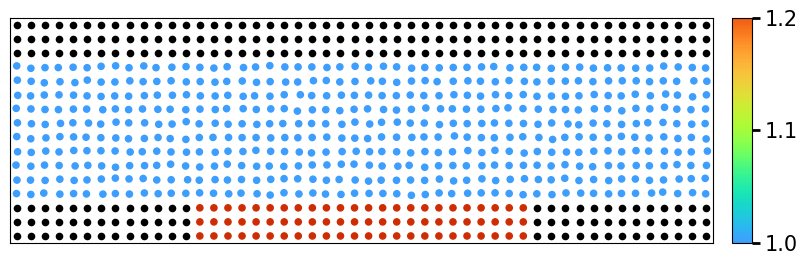

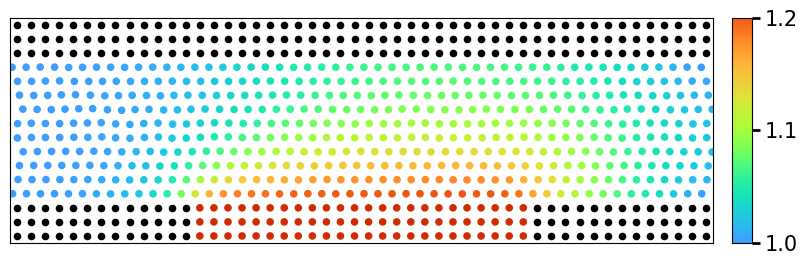

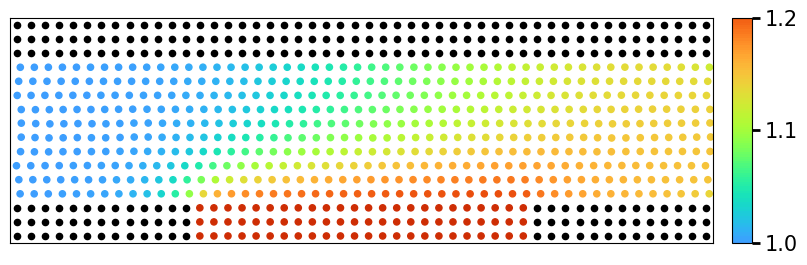

In [14]:
def paper_plots(data_dir, plt_dir, steps):
    """Create the three plots from the paper appendix."""

    metadata = OmegaConf.load(os.path.join(data_dir, "config.yaml"))

    for idx in steps:
        filename = f"{data_dir}/traj_{idx:04d}.h5"
        data_dict = read_h5(filename, array_type="numpy")
        r = data_dict["r"]
        v = data_dict["T"]
        tag = data_dict["tag"]
        wall_mask = tag == Tag.SOLID_WALL
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.scatter(
            r[~wall_mask][:, 0],
            r[~wall_mask][:, 1],
            vmin=0.93,
            vmax=1.27,
            c=v[~wall_mask],
            cmap="turbo",
            s=20,
        )
        ax.scatter(r[wall_mask][:, 0], r[wall_mask][:, 1], c="black", s=20)
        ax.set_xlim(metadata.case.bounds[0])
        ax.set_ylim(metadata.case.bounds[1])
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid()

        # add colorbar right of the image
        fig.tight_layout()
        fig.subplots_adjust(bottom=0.2)
        cax = fig.add_axes([0.87, 0.2, 0.02, 0.75])

        cbar = fig.colorbar(
            ax.collections[0],
            cax=cax,
            orientation="vertical",
            ticks=[1.0, 1.1, 1.2],
            boundaries=np.linspace(1.0, 1.2, 100),
            values=np.linspace(1.0, 1.2, 99),
        )

        cbar.ax.tick_params(
            labelsize=15,
            length=6,
            width=2,
        )

        os.makedirs(plt_dir, exist_ok=True)
        fig.savefig(f"{plt_dir}/HT_T_{idx}.pdf", bbox_inches="tight")
        plt.show()
        plt.close()

paper_plots(data_dir, plt_dir, steps=[0, 1000, 3000])

And for the gif in our documentation, use the following.

In [15]:
def docs_gif(data_dir, plt_dir):
    """Create a gif over all 3000 steps of the simulation."""

    metadata = OmegaConf.load(os.path.join(data_dir, "config.yaml"))
    bounds = metadata.case.bounds

    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith(".h5")]
    # sort files by index
    files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
    files = files[::2]

    fig = plt.figure(figsize=(bounds[0][1] * 10, bounds[1][1] * 10))
    ax = plt.axes(xlim=(bounds[0]), ylim=(bounds[1]))

    # Function to plot a single frame
    def update_plot(i):
        # get data
        filename = os.path.join(data_dir, files[i])
        data_dict = read_h5(filename, array_type="numpy")
        r = data_dict["r"]
        v = data_dict["T"]  # temperature
        tag = data_dict["tag"]
        wall_mask = tag == Tag.SOLID_WALL

        # plot data
        ax.clear()
        ax.scatter(
            r[~wall_mask][:, 0],
            r[~wall_mask][:, 1],
            vmin=0.93,
            vmax=1.27,
            c=v[~wall_mask],
            cmap="turbo",
            s=20,
        )
        ax.scatter(r[wall_mask][:, 0], r[wall_mask][:, 1], c="black", s=20)
        ax.set_xlim(metadata.case.bounds[0])
        ax.set_ylim(metadata.case.bounds[1])
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid()

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    anim = animation.FuncAnimation(fig, update_plot, frames=len(files), interval=20)

    os.makedirs(plt_dir, exist_ok=True)
    anim.save(f"{plt_dir}/anim.gif", writer="imagemagick", fps=30, dpi=50)
    plt.show()
    plt.close()

docs_gif(data_dir, plt_dir)

We also include utilities for visualizing physical properties like kinetic energy.

In the plot below we see that the channel flow starts from zero kinetic energy, and over the course of the simulation the fluid is accelerated to reach a nearly converged kinetic energy after 3300 simulation steps (note: we write every 100th simulation frame and thus have 33 recorded frames).

We also see that the negative lowest energy is close to zero, which is is line with some fluid moving very slowly close to the no-slip walls.

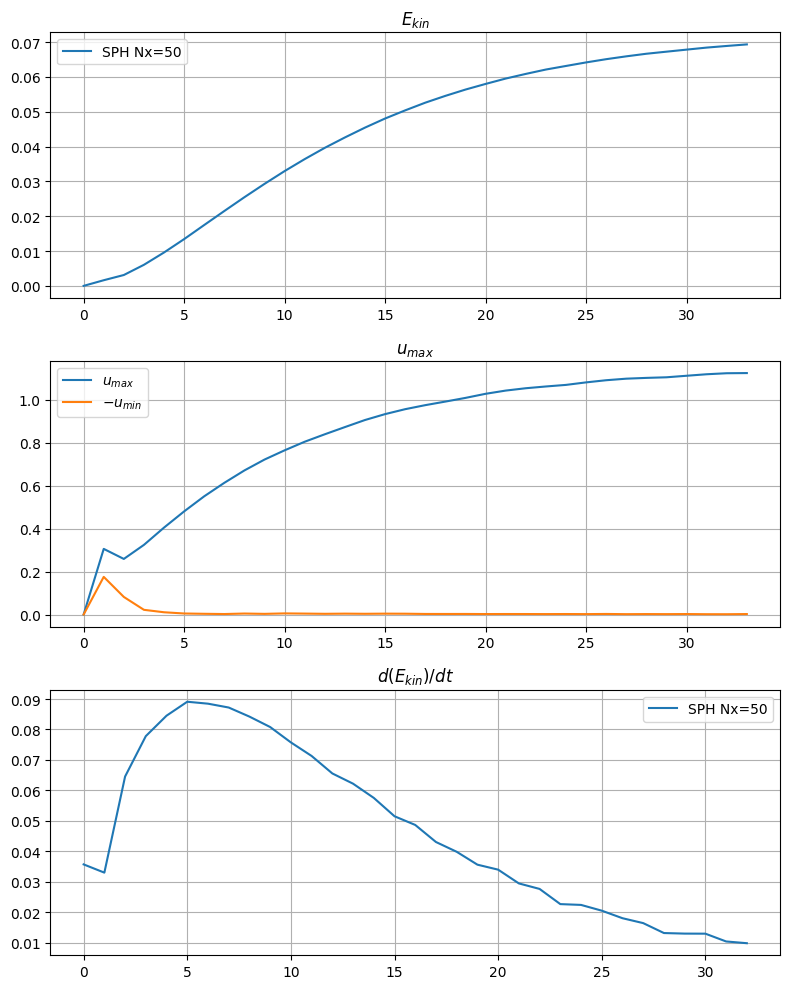

Finished data/debug/2D_HT_SPH_123_20240525-031102!


In [16]:
plt_ekin(data_dir)